In [1]:
import sys
sys.path.append('../helpers')

## Binary classification using hyperplanes

A **hyperplane** of $\mathbb{R}^p$ is an affine subspace of dimension $p - 1$.
Common examples are hyperplanes of $\mathbb{R}^2$, which are lines, and hyperplanes of $\mathbb{R}^3$ which are planes.
Hyperplanes are linear varieties described by one linear equation, and they don't have to pass through the origin.
A hyperplane of $\mathbb{R}^p$ is described by the equation:

$$\lambda_0 + \lambda_1 x_1 + \ldots + \lambda_p x_p = 0$$

Such hyperplane divides the space $\mathbb{R}^p$ in two halves:

$$
\begin{align}
    \lambda_0 + \lambda_1 x_1 + \ldots + \lambda_p x_p < 0 \\
    \lambda_0 + \lambda_1 x_1 + \ldots + \lambda_p x_p > 0
\end{align}
$$

This property makes hyperplanes very convenient for **binary** classification problems, when the positive class is identified by label $1$, and the negative class by label $-1$.

As an example, consider a classification problem of points whose inputs only have 2 dimensions, $x_1$ and $x_2$.
If we plot these points and colour them blue or red, according to their class, we might see something similar to the following.

In [2]:
from svm import *

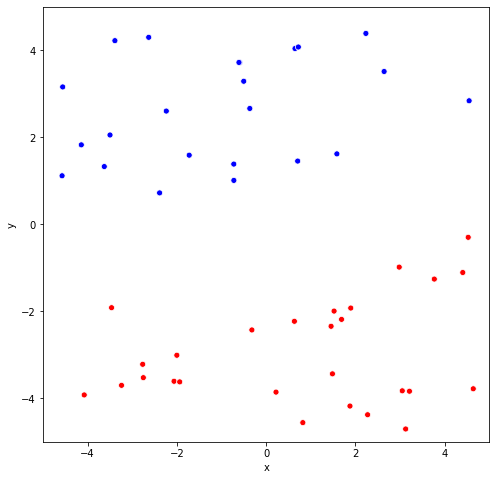

In [3]:
pts = LSPoints(random_state=0)
pts.plot();

In this case, I would argue that we have been extremely lucky because it looks like the two classes could be separated by drawing a straight line between them.
In other words, there is a hyperplane of $\mathbb{R}^2$ such that the points of one class lie on one side of it, and the points of the other class lie on the other side of it.
This hyperplane, therefore, separates the two classes.

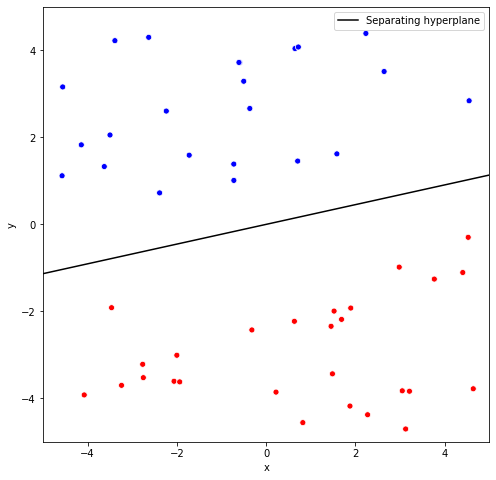

In [4]:
pts.plot(draw_separator=True);

If we are in such a well-behaved case, we can just select any hyperplane that classifies our data.
In the general case, the hyperplane will be defined by an equation similar to the one we have seen before:

$$\lambda_0 + \lambda_1 x_1 + \ldots + \lambda_p x_p = 0$$

Say that the points of class $1$ lie above this hyperplane (case $>0$ as seen before) and the points of class $-1$ lie below this hyperplane (case $<0$ as seen before).
In this case, it's easy to create a classification model.
When we are presented with a new, unknown point $(\bar{x}_1, \ldots, \bar{x}_p)$ that we want to classify, we simply have to plug it in the equation above:

$$\bar{y} = \lambda_0 + \lambda_1 \bar{x}_1 + \ldots + \lambda_p \bar{x}_p$$

Then, our prediction $\hat{y}$ will simply check on which side of the hyperplane the point $\bar{x}$ lies:

$$\hat{y} = \begin{cases} 1 & \text{ if } \bar{y} > 0 \\ -1 & \text{ if } \bar{y} \leq 0 \end{cases}$$

(Note that we arbitrarily selected class $-1$ in the case the point lies exactly on the hyperplane.
Such an event occurs, anyway, with probability zero.)

The hyperplane that separates the two classes is not unique.
In the picture below, we can see how shifting the classifying hyperplane a little bit usually gives us another classifying hyperplane.

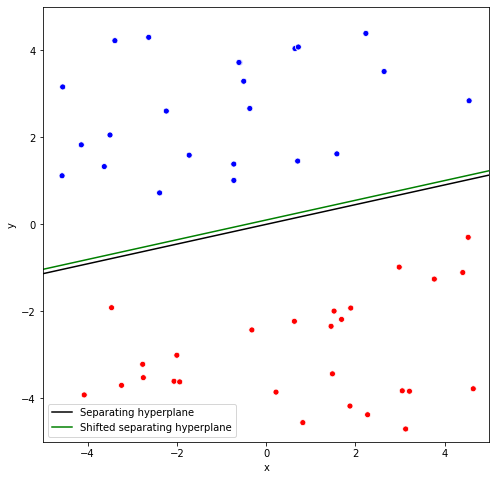

In [5]:
pts.plot(draw_separator=True, draw_shifted=True);

The same applies if we *rotate* the hyperplane a little bit, instead of shifting it.

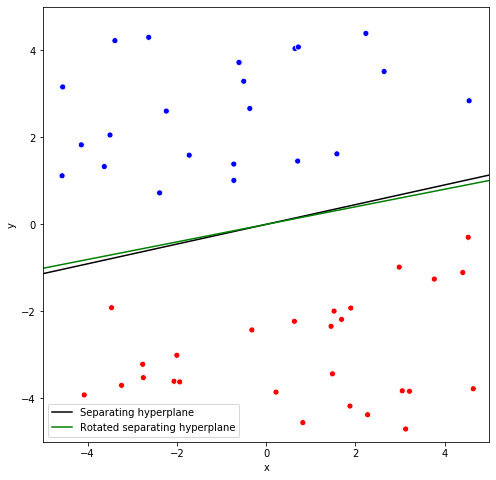

In [6]:
pts.plot(draw_separator=True, draw_rotated=True);

## The maximal margin classifier

The observations above prompt the following question: when given linearly classifiable data, which of the many (indeed, infinitely many) possible separating hyperplanes should we choose?
The intuitive answer is that we should choose the one which is **farthest away from the nearest point.**

In the example above, if we choose a line very close to a point $X$ of the blue class, we risk making a mistake:
when given a new unseen point very close to $X$, it might happen that it will lie on the other side of the classifier just by a little bit, but it really belongs to the blue class.

If we then call **margin** the smallest distance between a hyperplane and any of the points in the training set, what we are looking for is the hyperplane which separates the two classes and has the highest possible margin.
This hyperplane is called the **maximal margin classifier**.

Before asking ourselves how to find it, however, we have to give a precise definition of the *distance* of a point to a hyperplane.
In the two-dimensional case, we know it's the length of the segment passing through the point and perpendicular to the line.
Analogously, in the $p$-dimensional case, it will be the length of the segment passing through the point and orthogonal to the hyperplane.

![](../figures/mmc.png)

This picture from the ISML book gives a good idea of how a maximal margin classifier (MMC) looks like in two dimensions.
**Notice that the MMC will be equidistant from the closest point of each class.**
This means that the MMC is really **determined only by a handful of points: one point in one class, and one point in the other class; or a few more, like in the picture above for the two blue points, if there is more than one point attaining the smallest margin.**
Whatever configuration and distribution the points have far away from the boundary between the classes, this will not have any impact in determining the MMC.
In other words, in the picture above, we can move around a little bit all the points but for the ones with an arrow, and the MMC would not change.
On the other hand, if we move those three points, then the MMC will move too.

For this reason, the points we see in the picture with an arrow are particularly important.
They are called the support points or, since a point in $\mathbb{R}^p$ can be thought of as a vector, the **support vectors** of the MMC.

## Finding a maximal margin classifier

We are now interested in formulating a mathematical maximisation problem to find the MMC.
Before doing so, we have to make an observation which will help us with calculations in the following.
Notice that if a hyperplane is described by $\lambda_0 + \lambda_1 x_1 + \ldots + \lambda_p x_p = 0$, then it is equivalently described by $k (\lambda_0 + \lambda_1 x_1 + \ldots + \lambda_p x_p) = 0$ for any $k \neq 0$.
In other words, we can scale each coefficient by a factor $k$ and obtain new coefficients $\lambda_0', \ldots, \lambda_p'$, and they would also describe the same hyperplane.

In particular, we could choose $k = \frac{1}{\sqrt{\lambda_0^2 + \ldots + \lambda_p^2}}$.
It's easy to see that, in this case, the relationship $\sum_{i=0}^p {\lambda_i'}^2 = 1$ holds.
Therefore, when considering a hyperplane it's always possible to describe it with an equation whose parameters $\lambda_0, \ldots, \lambda_p$ are such that $\lambda_0^2 + \ldots + \lambda_p^2 = 1$.
In the following, we will always assume that this is the case, and we say that the coefficients are *normalised*.

This is very convenient, because it simplifies calculations.
For example, given a data point $(\bar{x}_1, \ldots, \bar{x}_p)$ with class $\bar{y}$, one can show that the perpendicular distance between this point and the hyperplane $\lambda_0 + \lambda_1 x_1 + \ldots + \lambda_p x_p = 0$ is exactly

$$\bar{y} (\lambda_0 + \lambda_1 \bar{x}_1 + \ldots + \lambda_p \bar{x}_p)$$

We are, then, ready to formlate the maximisation problem to find the MCC.
Let our training set be $\{x_1, \ldots, x_n\}$, where a point $x_i$ can be written as $(x_{i1}, \ldots x_{ip})$.
Let the labels be $y_1, \ldots, y_n$,**where each label $y_i$ is either $1$ or $-1$.**
Then, to find the MMC means to solve the following problem:

$$
\begin{align}
    \max_{\substack{\lambda_0, \ldots, \lambda_p \in \mathbb{R} \\ M \geq 0}} \quad & M \\
    \text{such that} \quad & \lambda_0^2 + \ldots + \lambda_p^2 = 1 \\
    \quad & y_i ( \lambda_0 + \lambda_1 x_{i1} + \ldots + \lambda_p x_{ip} ) \geq M & \quad & \forall i \in \{ 1, \ldots, n \}
\end{align}
$$

Here $\lambda_0, \ldots, \lambda_p$ will be the coefficients used to describe the hyperplane.
$M$, instead, is a variable holding the value of the margin.

* Because we want to maximise the margin, the objective function simply asks to find the maximal $M$.
* The first equality imposes the condition we mentioned above about coefficient normalisation.
* In the next line, we have an inequality.
By what we said before, we know that the left hand side is the distance between point $i$ and the hyperplane.
We are saying that this distance is $\geq M$ for all points.
In other words, we are saying that $M$ needs to be **smaller or equal than the smallest distance.**
But because we are maximising $M$, it will end up being exactly equal to the smallest distance.
In other words, it will end up getting exactly the value that we defined as the "margin".
With this inequality, therefore, we give meaning to variable $M$ saying that it will hold the value of the margin.

## When we are not so lucky...

As we said before, we can separate two classes with a hyperplane... **provided that they are linearly separable!**
Most real data in classification problems, however, is not so neat and is not lineraly separable.
If we draw a line anywhere in the plane, for example, we would see some misclassified points: point of one class which lie on the half-plane of the other class.

We have, therefore, to **think about a model which is able to handle a few misclassifications.**
Actually, even if the training data were linearly classifiable, we might **still want to prefer a model with misclassifications to one without.**
Why is it so?
Well, **because perfect linear classifiers exhibit high variance and might not generalise well to unknown data.**
This is explained well in the following picture from ISML, where the addition of just one data point to the training set changes the MMC drastically.

![](../figures/mmc_var.png)

A type of classifier which is able to handle misclassification in the training set is the **support vector classifier**.
The basic idea is to choose a hyperplane which classifies correctly most of the training points, but could misclassify some of them.
To describe such hyperplane, we have to introduce a few variables in the maximisation problem we stated before.
In particular, we add $n$ new variables $\epsilon_1, \ldots, \epsilon_n \in \mathbb{R}^+$ which will have the following value:

* If the $i$-th point is classified correctly and the distance between $X_i$ and the hyperplane is larger than $M$, then $\epsilon_i = 0$;
* If the $i$-th point is classified correctly, but its distance to the hyperplane is smaller than $M$ (let's say that it is in the "danger area"), then $\epsilon_i > 0$ but still $\epsilon_i \leq 1$.
* Finally, if the point is misclassified (it lies on the wrong side of the hyperplane), we will have $\epsilon_i > 1$.

As we can see, in this case $M$ does not work as a hard margin as before, because there can be observations (those for which $0 < \epsilon_i \leq 1$) which are closer than $M$ to the hyperplane.
Having these observations, however, is penalised via the variables $\epsilon_i$.
Therefore, $M$ will work as a *soft* margin: if we are farther than $M$ from the hyperplane, all good and $\epsilon_i = 0$; if we are on the right side, but we don't respect the soft margin, we get a small penalty $0 < \epsilon_i \leq 1$; if we are completely on the wrong side of the hyperplane, we get a large penalty $\epsilon_i > 1$.
We only have to make sure that we stay within reasonable limits with misclassification: this is done by imposing a maximum to the sum of the penalties $\epsilon_i$.

We are now ready to present the maximisation model that will describe the reasoning above.

$$
\begin{align}
    \max_{\substack{
        \lambda_0, \ldots, \lambda_p \in \mathbb{R} \\
        \epsilon_1, \ldots, \epsilon_n, \geq 0\\
        M \geq 0
    }} \quad & M \\
    \text{such that} \quad & \lambda_0^2 + \ldots + \lambda_p^2 = 1 \\
    \quad & y_i ( \lambda_0 + \lambda_1 x_{i1} + \ldots + \lambda_p x_{ip} ) \geq M (1 - \epsilon_i) & \quad & \forall i \in \{ 1, \ldots, n \} \\
    \quad & \epsilon_1 + \ldots + \epsilon_n \leq C \\
\end{align}
$$

It is interesting to note that there is a parameter $C$ which is bounding the sum of the values of the variables $\epsilon_i$, as we said above.
What is the practical role of this parameter?
**It allows us to tolerate more or less misclassifications!**
If $C = 0$ then we are forcing all $\epsilon_i$ to be $0$ and, therefore, we are back to the model we had before: we are back to the MMC.
The more we increase $C$, the larger the values that the $\epsilon_i$ can take.
This means that more misclassifications are allowed.

In other words, $C$ is a **parameter that we can use to shift the bias-variance trade-off towards "bias" or towards "variance".
When $C = 0$ we have the model with most variance, but also the smallest number of misclassifications, and so the lowest bias.**
(Provided a MMC exists in the first place, i.e., provided that the data is linearly classifiable; if this is not the case, the no MMC exists or, in other words, setting $C=0$ produces an infeasible problem.)
Conversely, the more we increase $C$ the more misclassifications we allow, increasing the bias.
The model, however, will be less sensitive to the composition of the training dataset and, therefore, will show less variance.

In practice, we would choose which value for $C$ via **hyperparameter tuning, which is a fancy way to say: we try many values and settle on that which gives the smallest error.**
How do we quantify the error? Well, we use with one of the validation methods we have seen in the previous lectures.
For example, cross-validation.

We can also notice a similar property to the one we noticed for the MMC: **only the data points which produce some penalty $\epsilon_i > 0$ affect the value of the optimal parameters $\lambda_0, \ldots, \lambda_p$.**
If we take a point which is classified correctly and whose distance from the hyperplane is $\geq M$, and we move it around a bit, the values of the optimal $\lambda$'s will not be affected (provided that we keep the distance $\geq M$, of course).
In this case, too, we call those points that can affect the problem (the points which are either misclassified, or classified correctly but too close to the hyperplane) the *support vectors* of the hyperplane.

## Moving beyond the linear case

Up to now, we have only considered hyperplanes to separate the two classes in binary classification problems.
Clearly, there are cases when such a linear classifier does not perform very well, such as on the data below.

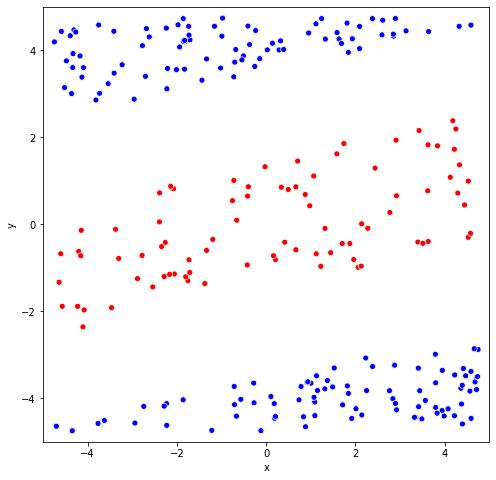

In [7]:
nl = StripePoints()
nl.plot();

Can you guess how a Support Vector Classifier would fare with such a dataset?

In [8]:
X, y = nl.df[['x', 'y']], nl.df['c']

In [9]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
from sklearn.svm import SVC

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25, random_state=0, stratify=y)

In [10]:
linear_svc = SVC(kernel='linear', max_iter=10000).fit(X_train, y_train)

In [11]:
pred = linear_svc.predict(X_test)

What is the accuracy of our classifier?

In [12]:
accuracy_score(y_test, pred)

0.6666666666666666

In [13]:
f1_score(y_test, pred)

0.8

Note that the classifier has low accuracy and the low F1-score.
In fact, the accuracy number is not entirely random...

In [14]:
len(y_test[y_test == 1]) / len(y_test)

0.6666666666666666

The classifier just predicted 1 for all points:

In [15]:
pred

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

The positive (+1) class, in fact, was the majority class in both the training and test set:

In [16]:
len(y_train[y_train == 1]) / len(y_train)

0.6631016042780749

This behaviour is also evident by plotting the correct and wrong predictions made by the classifier:

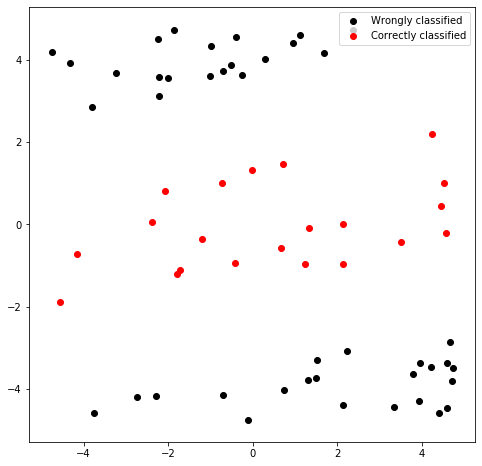

In [17]:
fig, ax = plt.subplots(figsize=(8,8))

for x, y, p in zip(X_test.values, y_test, pred):
    ax.scatter([x[0]], [x[1]], c=('k' if y == p else 'r'))

ax.legend(labels=['Wrongly classified', 'Correctly classified']);

Can you give an intuitive explanation of why the best the classifier can do in this case is to predict the majority class?

### Generalising the Support Vector Classifier

From the example above, it's clear that linear models cannot be used for all classification purposes.
Therefore, **we have to add non-linearities to our model, to help us draw more complex decision boundaries.**

Consider the following two examples, which we have explored in class using pen, paper and scissors, and which help us better understand one of the ways in which we can achieve non-linearity: *increasing the dimensionality of the space*.

#### Example 1

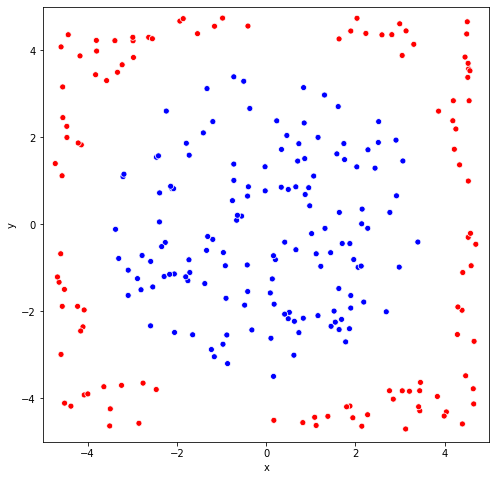

In [18]:
cp = CirclePoints()
cp.plot();

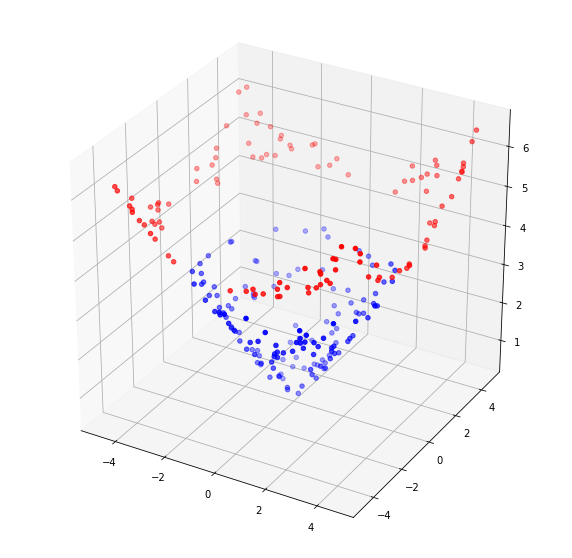

In [19]:
fig, ax = cp.plot3d()

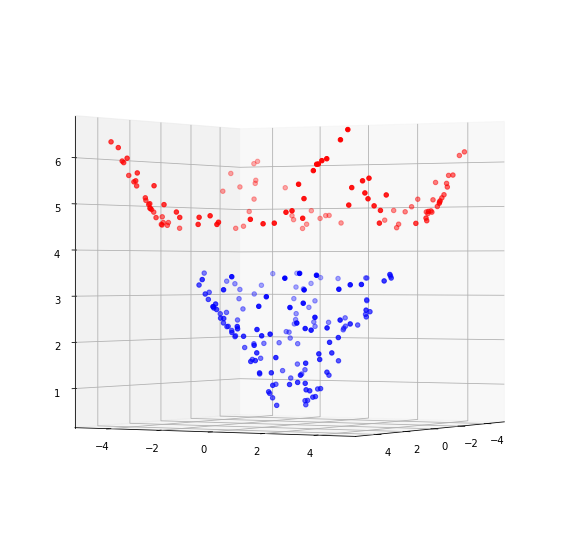

In [20]:
ax.view_init(0, 30)
fig

The dimension we added was $x_3 = \sqrt{x_1^2 + x_2^2}$.

#### Example 2

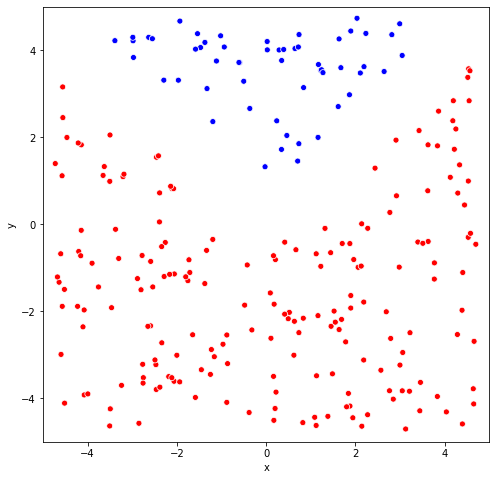

In [21]:
vp = VPoints()
vp.plot();

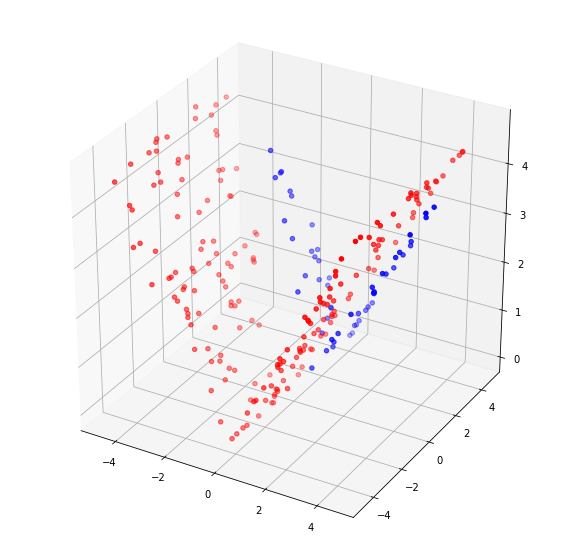

In [22]:
fig, ax = vp.plot3d()

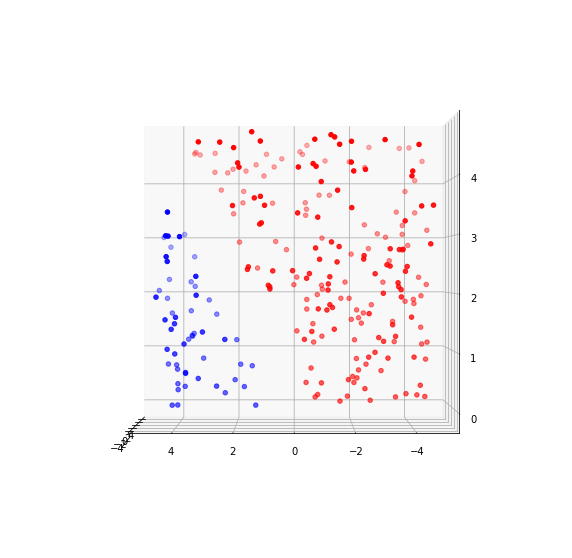

In [23]:
ax.view_init(0, 180)
fig

The dimension we added was $x_3 = |x_1|$.

From this examples we can get the intuition behind this powerful technique: **non-linear decision boundaries can be obtained in enlarged feature spaces, adding new dimensions which are (non-linear) functions of the original features.**
But which new dimensions should we add?
The space of transformation functions, such as $\sqrt{\cdot}$ and $|\cdot|$ that we used in the example, is infinitely large and thus impossible to explore completely.

This is where **support vector machines** (SVM) come to rescue us!
An SVM offers a way to perform implicit space augmentation, generalising the linear Support Vector Classifier we have seen above.

It can be shown that an analytical expression for the support vector classifier only involves the inner product of the input points.
In other words, the hyperplane can be written as
$$\lambda_0 + \sum_{i=1}^n \alpha_i \langle x, x_i \rangle$$
where $x_i$ is one datapoint $x_i = (x_{i1}, \ldots, x_{ip})$, $n$ is the size of the training set $\{x_1, \ldots, x_n\}$, and $\langle \cdot, \cdot \rangle$ is the inner product operator.
The $\alpha_i$ are parameters, which only depend on the inner product of the training points; these inner products have the form $\langle x_i, x_j \rangle$, for $i, j \in \{1,\ldots,n\}$ with $i \neq j$.

The idea behind the SVM is to generalise the inner product and substitute it with a generic function $K(x_i, x_j)$.
This function being non-linear, we are able to introduce nonlinearity in the decision boundary.

There are two good news for us users:
* The first is that many functions $K$ can be computed almost as efficiently as inner products. Therefore, using non-linear kernels doesn't carry a too large computational burden.
* The second is that there is a list of popular kernel functions which are frequently used and work well for many types of non-linearities in the data. Therefore, we don't have to explore an infinitely large space of non-linear function, but can restrict ourselves to the most commonly used kernels.

Popular kernels are (in the following, $\gamma$ is a hyperparameter.
* The polynomial kernel of degree $d$, $K(x_i, x_j) = \big(1 + \gamma \sum_{k=1}^p x_{ik} x_{jk}\big)^d$.
* The radial kernel (RBF): $K(x_i, x_j) = e^{-\gamma \sum_{k=1}^p (x_{ik} - x_{jk})^2}$.
* The sigmoid kernel: $K(x_i, x_j) = \tanh \big( 1 + \gamma \sum_{k=1}^p x_{ik} x_{jk} \big)$.

With the following code, I show a crude example (e.g., no hyperparameter tuning) of how the different kernels behave when classifying the two dataset we have seen earlier: the "circular" one and the "V" one.

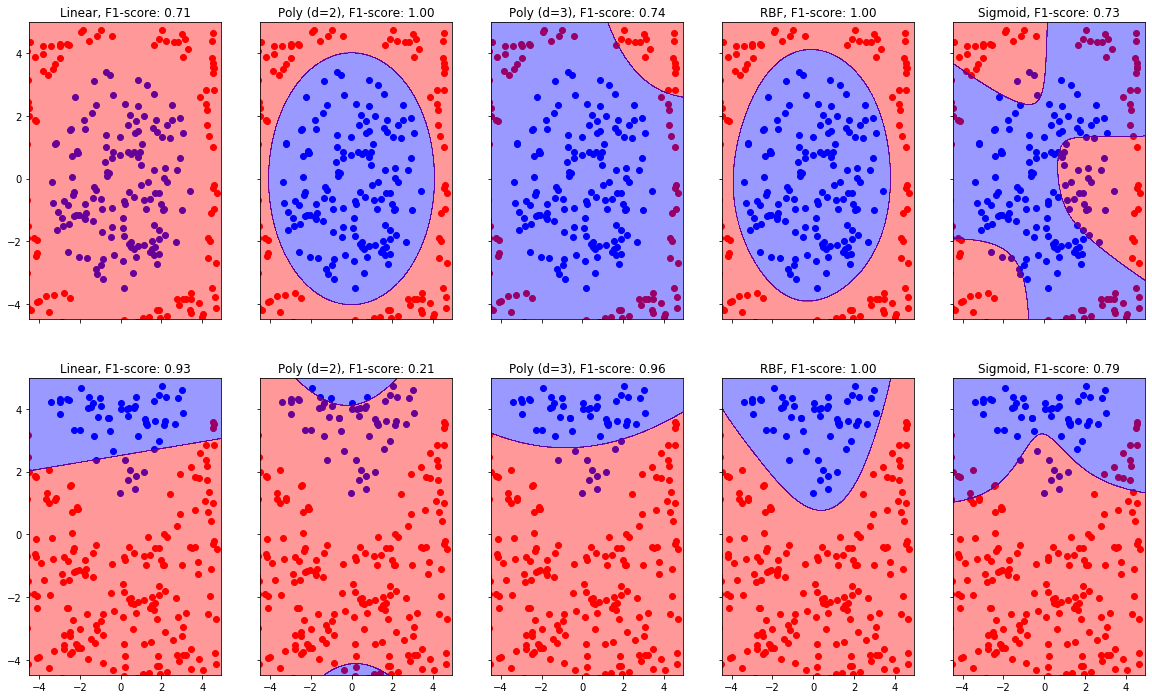

In [24]:
models = [
    dict(name='Linear', model=SVC(kernel='linear')),
    dict(name='Poly (d=2)', model=SVC(kernel='poly', degree=2, gamma='scale')),
    dict(name='Poly (d=3)', model=SVC(kernel='poly', degree=3, gamma='scale')),
    dict(name='RBF', model=SVC(kernel='rbf', gamma='scale')),
    dict(name='Sigmoid', model=SVC(kernel='sigmoid', gamma='scale'))
]

fig, axes = plt.subplots(2, len(models), figsize=(20,12), sharex='col', sharey='row')
plot_id = 0

for data in [cp.df, vp.df]:
    X, y = data[['x', 'y']], data['c']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25, random_state=0, stratify=y)
       
    xmin, xmax = X.x.min() * .95, X.x.max() * 1.05
    ymin, ymax = X.y.min() * .95, X.y.max() * 1.05
    xx, yy = np.meshgrid(np.arange(xmin, xmax, 0.01), np.arange(ymin, ymax, 0.01))
    
    for model in models:
        m = model['model']
        m.fit(X_train, y_train)
        
        pmesh = m.predict(np.c_[xx.ravel(), yy.ravel()])
        pmesh = pmesh.reshape(xx.shape)
        
        ax = axes.flat[plot_id]
        dp = data[data.c == 1]
        dn = data[data.c == -1]
        
        ax.scatter(dp.x, dp.y, color='b')
        ax.scatter(dn.x, dn.y, color='r')
        ax.contourf(xx, yy, pmesh, alpha=.4, colors=['r', 'b'])
        ax.set_xlim((xmin, xmax))
        ax.set_ylim((ymin, ymax))
        ax.set_title(f"{model['name']}, F1-score: {f1_score(y_test, m.predict(X_test)):.2f}")
        
        plot_id += 1

### A note on how to choose the most appropriate kernel

**Kernel selection is a fundamental part in applying Support Vector Machines for classification.
It is always best to first apply any domain-specific insight on the data we have, to see if one of the kernels makes the most sense.**
If this is not the case, a first choice (by some sort of *Occam's razor*) should be a linear kernel.
If the data is clearly not linearly separable, RBF kernels are a very popular choice and could be considered next.

For each kernel function, we should also **tune the hyper-parameters of the model.**
These are at least the $C$ parameter we have already seen for SVCs, and the $\gamma$ we have introduced above.
A way to tune the parameters could be via **grid search combined with cross-validation.**
**If grid search proves too expensive (as it is very likely if the number of parameters grows beyond a few units) one can look into other quicker methods, such as the Nelder-Mead method.**

One could also imagine to add the kernel as an additional hyperparamter to tune: $\text{kernel} \in \{ \text{linear}, \text{poly}, \text{rbf}, \text{sigmoid}, \ldots \}$.
A word of caution, however!
**Overfitting a SVM is really easy.
Given the large choice of kernels and the number of hyperparameters, it is possible to find a combination that "accidentally" works well on the training set, but does not generalise very well.**
For this reason, we always **recommend to base the choice of the kernel on some inspection of the data, and resort to automatical kernel selection only if everything else fails.**
You can find more information, for example, in [this article](https://www.kdnuggets.com/2016/06/select-support-vector-machine-kernels.html), [this thread](https://stats.stackexchange.com/questions/18030/how-to-select-kernel-for-svm) and [this thread](https://stats.stackexchange.com/questions/73032/linear-kernel-and-non-linear-kernel-for-support-vector-machine) (notice, "Gaussian kernel" is another name for RBF).